In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scipy.sparse
import numpy as np
import os
import seaborn as sns
from IPython.display import display, HTML

In [3]:
metadata = pd.read_csv('/homefolder/royl/CNV/CopyKat/TNBC/TNBC_metadata.csv', index_col=0)

/tmp/ipykernel_1605/2433875914.py:1: DtypeWarning: Columns (1,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,22,23,25,27,28,29,30,36,38,40,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,72,73,74,75,77,78,80,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,103,104,106,107,108,112,113,114,115,116,118,121,122,123,124,125,126,127,128,129,130,132,133,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/homefolder/royl/CNV/CopyKat/TNBC/TNBC_metadata.csv', index_col=0)


In [4]:
os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/')

In [5]:
samples_all = ["BIOKEY_1_Pre", "BIOKEY_2_Pre", "BIOKEY_8_Pre", "BIOKEY_9_Pre", "BIOKEY_10_Pre", "BIOKEY_11_Pre", "BIOKEY_14_Pre", "BIOKEY_15_Pre", "BIOKEY_16_Pre", "BIOKEY_19_Pre", "BIOKEY_25_Pre", "BIOKEY_26_Pre", "BIOKEY_31_Pre", "CID44971", "sc5rJUQ042", "GSM4909282", "scrJUQ070", "CID44041", "CID44991", "scrJUQ068", "CID4515", "CID4523", "CID4513", "GSM4909284", "GSM4909283", "sc5rJUQ058", "sc5rJUQ039", "sc5rJUQ045", "CID4465", "sc5rJUQ051", "CID3946", "CID4495", "TBB165", "sc5rJUQ026", "sc5rJUQ053", "sc5rJUQ033", "GSM5457208", "GSM4909281", "GSM5457199", "scrJUQ059","BIOKEY_1_On",
"BIOKEY_11_On"]

good_samples = ["BIOKEY_1_Pre", "BIOKEY_2_Pre", "BIOKEY_9_Pre","BIOKEY_10_Pre", "BIOKEY_11_Pre", "BIOKEY_15_Pre", "BIOKEY_16_Pre", "BIOKEY_25_Pre", "BIOKEY_26_Pre", "BIOKEY_31_Pre", "CID44971", "GSM4909282", "scrJUQ070", "CID44991", "scrJUQ068", "CID4515", "CID4523", "GSM4909284", "sc5rJUQ045", "CID4465", "CID4495", "TBB165", "sc5rJUQ053", "sc5rJUQ033", "GSM5457208", "GSM4909281", "GSM5457199", "scrJUQ059",]

In [4]:
for i in good_samples:
    print(i)

BIOKEY_1_Pre
BIOKEY_2_Pre
BIOKEY_9_Pre
BIOKEY_11_Pre
BIOKEY_15_Pre
BIOKEY_16_Pre
BIOKEY_25_Pre
BIOKEY_26_Pre
BIOKEY_31_Pre
CID44971
GSM4909282
scrJUQ070
CID44991
scrJUQ068
CID4515
CID4523
GSM4909284
sc5rJUQ045
CID4465
CID4495
TBB165
sc5rJUQ053
sc5rJUQ033
GSM5457208
GSM4909281
GSM5457199
scrJUQ059


In [ ]:
BIOKEY_1_Pre BIOKEY_2_Pre BIOKEY_9_Pre BIOKEY_11_Pre BIOKEY_15_Pre BIOKEY_16_Pre BIOKEY_25_Pre BIOKEY_26_Pre BIOKEY_31_Pre CID44971 GSM4909282 scrJUQ070 CID44991 scrJUQ068 CID4515 CID4523 GSM4909284 sc5rJUQ045 CID4465 CID4495 TBB165 sc5rJUQ053 sc5rJUQ033 GSM5457208 GSM4909281 GSM5457199 scrJUQ059

In [5]:
pwd

'/homefolder/royl/CNV/CopyKat/pipelines'

# Functions

> The script is to be located in a directory where the folders with the copyKAT outputs are. Each sample has a folder with it's CopyKat outputs (CNV matrix and prediction file). The foldername must be the sample name as in the metadata "SampleId".
Change directories in the functions if needed.

In [6]:
def aggregate_columns(adata,annotate_by=None): # (By band - Default, By set of genes: 'genes') 
    # Initialize variables for tracking bins and constructing the new DataFrame
    df = adata.to_df()
    band_dict = dict(zip(adata.var.index,adata.var.band))
    chr_dict = dict(zip(adata.var.index,adata.var.chromosome_name))
    bins = []
    current_bin = [df.columns[0]]  # Start with the first column as the initial bin

    # Iterate over columns to group them into bins
    for col in df.columns[1:]:
        # If the entire column matches the previous column, add it to the current bin
        if (df[col] == df[current_bin[-1]]).all():
            current_bin.append(col)
        else:
            # Current column does not match, store the current bin and start a new one
            bins.append(current_bin)
            current_bin = [col]

    # Don't forget to add the last bin
    bins.append(current_bin)
    # Creating a new DataFrame based on bins
    aggregated_data = {}
    band_title_by_genes = {}
    for bin_cols in bins: #bin_cols - a column name made of the set of genes relevant to the bin 
        # The new column name is a concatenation of the original column names
        
        new_col_name = ','.join(bin_cols)
        if chr_dict[bin_cols[0]] == chr_dict[bin_cols[-1]]:
            band_title = band_dict[bin_cols[0]] +'-' +band_dict[bin_cols[-1]]+',chr'+str(chr_dict[bin_cols[0]])
        else:
            band_title = band_dict[bin_cols[0]] +'-' +band_dict[bin_cols[-1]]+',chr'+str(chr_dict[bin_cols[0]]) +'-chr'+str(chr_dict[bin_cols[-1]])
            
        # Use the first column in the bin to represent its value
        aggregated_data[new_col_name] = df[bin_cols[0]]
        # gene set to be applied on data.var
        band_title_by_genes[new_col_name] = band_title
        
    aggregated_data = sc.AnnData(pd.DataFrame(aggregated_data, index=df.index))
    aggregated_data.var['by_band'] = aggregated_data.var.index.map(band_title_by_genes).astype('str')
    aggregated_data.var['gene_set'] = aggregated_data.var.index
    aggregated_data.var.set_index('by_band',inplace=True)
    aggregated_data.var_names_make_unique(join = ' -')
    
    aggregated_data.obs = adata.obs
    
    return aggregated_data

In [16]:
def CNVmtx_ad_and_top_CNVs(sample,meta):  # Creates an adata object for an individual sample, displays PCA,rank_gene_groups(top CNVs) plots, and returns and adata object + DE data (in uns) 
    pd.options.mode.copy_on_write = True
    os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/')
    
    cnv_mtx = pd.read_csv(sample+'/'+sample+'_copykat_CNA_raw_results_gene_by_cell.txt',sep='\t') # CNV mtx
    prediction = pd.read_csv(sample+'/'+sample+'_copykat_prediction.txt',delimiter='\t',index_col=0) # Prediction by idx
    pred_dict = dict(zip(prediction.index,prediction['copykat.pred'])) # Prediction by idx dict
    # var metadata
    cnv_mtx.set_index('hgnc_symbol',inplace=True)    
    var = cnv_mtx.iloc[:,:6].copy() # keep for var metadata
    
    # Mtx to anndata (ad)
    cnv_mtx = cnv_mtx.iloc[:,6:].copy()
    plt.hist(cnv_mtx.values.flatten(), bins=50, color='skyblue')

    cnv_mtx = sc.AnnData(cnv_mtx)
    cnv_mtx = cnv_mtx.T
    cnv_mtx.var = var.iloc[:,:6]

    # obs metadata
    cnv_mtx.obs = meta[meta.index.isin(cnv_mtx.obs_names)]
    cnv_mtx.obs['prediction'] = cnv_mtx.obs.index.map(pred_dict).astype('category')

    os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/'+sample)

    cnv_mtx = aggregate_columns(cnv_mtx)
    
    # PCA plots 
    sc.tl.pca(cnv_mtx, svd_solver="arpack")   
    sc.pl.pca(cnv_mtx, color=["prediction",'cnv_status','major_cell_type'],wspace=0.2)
    sc.pl.pca(cnv_mtx, color=['major_cell_type'],)
    sc.pl.pca(cnv_mtx[cnv_mtx.obs.major_cell_type=='Epithel'], color=['minor_cell_type'],frameon=False)

    # Rank_groups 
    cnv_mtx_copy = cnv_mtx.copy()
    cnv_mtx_copy.obs['copykat_cnv']= cnv_mtx_copy.obs.prediction.replace({'aneuploid':'duplications','diploid':'deletions'})
    vmin=np.min(cnv_mtx_copy.X)
    cnv_mtx_copy.X = cnv_mtx_copy.X-vmin

    
    sc.tl.rank_genes_groups(cnv_mtx_copy, 'copykat_cnv', method='t-test') 
    sc.pl.rank_genes_groups(cnv_mtx_copy, n_genes=25, sharey=False)
    pd.set_option("display.max_columns", None)
    display(pd.DataFrame(cnv_mtx_copy.uns['rank_genes_groups']['names']).head(20))
    sc.pl.rank_genes_groups_heatmap(cnv_mtx_copy,n_genes=5,cmap='RdBu_r',groupby='prediction',dendrogram=False,standard_scale =None,vcenter=-vmin,save='heatmap_de_'+sample+'.png')
    dup_de = sc.get.rank_genes_groups_df(cnv_mtx_copy, group="duplications").set_index('names')
    dup_de['mean_cnv_aneuploid'] = cnv_mtx[cnv_mtx.obs['prediction'] == 'aneuploid'].to_df().mean()
    display(dup_de.head(20))

    cnv_mtx.uns = cnv_mtx_copy.uns.copy()
    del(cnv_mtx_copy)
    
    return cnv_mtx,dup_de
    
    

In [5]:
def CNV_adata_w_zscore(sample,meta):  #  CNVmtx_and_top_CNVs with Z- score normaliztion 120524
    #  Creates an adata object for an individual sample, displays PCA,rank_gene_groups(top CNVs) plots, and returns and adata object + DE data (in uns) 
    pd.options.mode.copy_on_write = True
    os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/')
    
    cnv_mtx = pd.read_csv(sample+'/'+sample+'_copykat_CNA_raw_results_gene_by_cell.txt',sep='\t') # CNV mtx
    prediction = pd.read_csv(sample+'/'+sample+'_copykat_prediction.txt',delimiter='\t',index_col=0) # Prediction by idx
    pred_dict = dict(zip(prediction.index,prediction['copykat.pred'])) # Prediction by idx dict
    # var metadata
    cnv_mtx.set_index('hgnc_symbol',inplace=True)    
    var = cnv_mtx.iloc[:,:6].copy() # keep for var metadata
    
    # Mtx to anndata (ad)
    cnv_mtx = cnv_mtx.iloc[:,6:].copy()
    plt.hist(cnv_mtx.values.flatten(), bins=50, color='skyblue')

    cnv_mtx = sc.AnnData(cnv_mtx)
    cnv_mtx = cnv_mtx.T
    cnv_mtx.var = var.iloc[:,:6]
    
    # obs metadata
    cnv_mtx.obs = meta[meta.index.isin(cnv_mtx.obs_names)]
    cnv_mtx.obs['prediction'] = cnv_mtx.obs.index.map(pred_dict).astype('category')

    os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/'+sample)

    cnv_mtx = aggregate_columns(cnv_mtx)
    
    # PCA plots 
    sc.tl.pca(cnv_mtx, svd_solver="arpack")   
    sc.pl.pca(cnv_mtx, color=["prediction",'cnv_status','major_cell_type'],wspace=0.2)
    sc.pl.pca(cnv_mtx, color=['major_cell_type'],)
    sc.pl.pca(cnv_mtx[cnv_mtx.obs.major_cell_type=='Epithel'], color=['minor_cell_type'],frameon=False)

    # pct cnv in cells 
    cnv_mtx_copy = cnv_mtx[cnv_mtx.obs.prediction=='aneuploid'].copy()
    # Deletions data pct
    cnv_mtx_copy.X[cnv_mtx_copy.X>0] = 0
    cnv_mtx_copy.X = -cnv_mtx_copy.X
    sc.pp.filter_genes(cnv_mtx_copy,min_cells=0,)
    cnv_mtx_copy.var['pct_cells'] = cnv_mtx_copy.var['n_cells']*100/cnv_mtx_copy.shape[0]
    del_pct_dict = dict(zip(cnv_mtx_copy.var[cnv_mtx_copy.var.pct_cells>50].index,cnv_mtx_copy.var[cnv_mtx_copy.var.pct_cells>50].pct_cells))
    # Amps data pct
    cnv_mtx_copy = cnv_mtx[cnv_mtx.obs.prediction=='aneuploid'].copy()
    cnv_mtx_copy.X[cnv_mtx_copy.X<0] = 0
    sc.pp.filter_genes(cnv_mtx_copy,min_cells=0,)
    cnv_mtx_copy.var['pct_cells'] = cnv_mtx_copy.var['n_cells']*100/cnv_mtx_copy.shape[0]
    amp_pct_dict = dict(zip(cnv_mtx_copy.var[cnv_mtx_copy.var.pct_cells>50].index,cnv_mtx_copy.var[cnv_mtx_copy.var.pct_cells>50].pct_cells))
        
    pct_dict = {**amp_pct_dict, **del_pct_dict}
    
    #____DE_____
    cnv_mtx_copy = cnv_mtx.copy()
    # Z- score normaliztion 
    df = cnv_mtx_copy.to_df().copy()

    row_means = df.mean(axis=1)
    row_stds = df.std(axis=1)

    cnv_mtx_copy = df.sub(row_means, axis=0).div(row_stds, axis=0)
    cnv_mtx_copy = sc.AnnData(cnv_mtx_copy)
    cnv_mtx_copy.obs['SampleId'] = cnv_mtx_copy.obs.index.astype('category').copy()
    # ___
    
    cnv_mtx_copy.obs['copykat_cnv']= cnv_mtx.obs.prediction.replace({'aneuploid':'duplications','diploid':'deletions'})
    sc.pp.filter_genes(cnv_mtx,min_cells=0)
    
    #In order to keep meaningful deletions (ref for normal cells cant be neg) 
    vmin=np.min(cnv_mtx_copy.X)
    display(vmin)
    cnv_mtx_copy.X = cnv_mtx_copy.X-vmin
    plt.hist(cnv_mtx_copy.to_df().values.flatten(), bins=50, color='#b3ff66')

    
    sc.tl.rank_genes_groups(cnv_mtx_copy, 'copykat_cnv', method='t-test',) # Can also be 'cell_type' once annotated
    sc.pl.rank_genes_groups(cnv_mtx_copy, n_genes=25, sharey=False)
    pd.set_option("display.max_columns", None)
    sc.pl.rank_genes_groups_heatmap(cnv_mtx_copy,n_genes=5,cmap='RdBu_r',groupby='copykat_cnv',dendrogram=False,standard_scale =None,vcenter=-vmin,save='heatmap_de_'+sample+'.png')
    dup_de = sc.get.rank_genes_groups_df(cnv_mtx_copy, group="duplications").set_index('names')
    dup_de['pct'] =dup_de.index.map(pct_dict).astype('float')
    dup_de['mean_cnv'] = cnv_mtx[cnv_mtx.obs['prediction'] == 'aneuploid'].to_df().mean()
    
    
    display(dup_de.head(20))

    cnv_mtx.uns = cnv_mtx_copy.uns.copy()
    del(cnv_mtx_copy)
    
    return cnv_mtx,dup_de
    
    

In [8]:
def cnv_integration(samples,meta): # Creates an adata object for an multiple samples, displays PCA plots, and returns the anndata integrated object 

    pd.options.mode.copy_on_write = True

    chr_dict={}
    start_dict={}
    band_dict = {}
    mtx =[]
    prediction = []
    for sample in samples:
        os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/'+sample)
        cnv_mtx = pd.read_csv(sample+'_copykat_CNA_raw_results_gene_by_cell.txt',sep='\t')
        cnv_mtx.set_index('hgnc_symbol',inplace=True)
        
        chr_dict = {**chr_dict,**dict(zip(cnv_mtx.index,cnv_mtx['chromosome_name']))}
        start_dict = {**start_dict,**dict(zip(cnv_mtx.index,cnv_mtx['start_position']))}
        band_dict = {**band_dict,**dict(zip(cnv_mtx.index,cnv_mtx['band']))}
                      
        prediction.append(pd.read_csv(sample+'_copykat_prediction.txt',delimiter='\t',index_col=0))        
        mtx.append(cnv_mtx.iloc[:,6:].T)
        
    
    concatenated_df = pd.concat(mtx, axis=0, join='outer')
    print('Data dimension: ',concatenated_df.shape)
    # Fill non present genes in a sample with zero (Unions) 
    concatenated_df = concatenated_df.fillna(0.000001)
    
    # Ordering by genome location
    concatenated_df = concatenated_df.T
    concatenated_df['chromosome_name'] = concatenated_df.index.map(chr_dict).astype('int')
    concatenated_df['start_position'] = concatenated_df.index.map(start_dict).astype('int')
    concatenated_df.sort_values(by=['chromosome_name','start_position'],ascending=[True,True],inplace=True)

    #Transforming to anndata
    concatenated_df = sc.AnnData(concatenated_df.iloc[:,:-2].T)
    
    #Adjusting metadata                             
    concatenated_df.var['chromosome_name'] = concatenated_df.var.index.map(chr_dict).astype('int')
    concatenated_df.var['start_position'] = concatenated_df.var.index.map(start_dict).astype('int')
    concatenated_df.var['band'] = concatenated_df.var.index.map(band_dict).astype('category')
    
    meta = meta[meta.index.isin(concatenated_df.obs_names)]
    # meta['prediction'] = ''
    prediction_all = pd.concat(prediction)    
    meta['prediction'] = prediction_all['copykat.pred'].reindex(meta.index)
    meta = meta.reindex(concatenated_df.obs.index)

    # meta.loc[meta.index.intersection(prediction_all.index), 'prediction'] = prediction_all.loc[meta.index.intersection(prediction_all.index), 'copykat.pred']
    concatenated_df.obs = meta.copy()
    
    # visualization 
    sc.tl.pca(concatenated_df, svd_solver="arpack")   
    sc.pl.pca(concatenated_df, color=["prediction",'SampleId'],wspace=0.3)
    sc.pl.pca(concatenated_df, color=['cnv_status','major_cell_type'],wspace=0.3)

    os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/')
    return(concatenated_df)

In [2]:
def create_individual_rank_table(individual_tables):
    individual_ranks = {}
    
    for individual, table in individual_tables.items():
        for rank, row in table.iterrows():
            for gene in row['genes_in_bin']:
                individual_ranks.setdefault(gene, {})[individual] = row['logfoldchanges']
                
    df = pd.DataFrame.from_dict(individual_ranks, orient='index')
    df.fillna(0, inplace=True)
    df['overall_count'] = df.astype(bool).sum(axis=1)
    
    return df

**heatmap(adata,col_cluster=False,only_tumor=True,infer_cnv=False,cell_ann='prediction',adata_type='single',save_plot = False)**
> Parameters 
- **adata** - an object created via CNVmtx_ad_and_top_CNVs or cnv_integration(samples,meta).
- **col_cluster** - Where or not to perform Ward clustering on the genes/bins. *Default False*- Shown by genomic coordinates order, *True*- clustered to create gene modules.
- **only_tumor** - Only show Epithelial cells predicted as aneuploid. *Default False*.
- **infer_cnv** - If *True*, prediction will be based by InferCNV high score (cnv_status) as in the metadata. *Default False*.
- **cell_ann** - Any categorical annotation in the metadata. ('prediction' - CopyKAT prediction (*default*), 'SampleId', 'major_cell_type' etc.).
- **adata_type** - 'single' (*default*) meaning a single sample anndata object, columns are bins. 'Multi'- Integrated samples anndata object.
- **normalization** - Z- score normaliztion, *Default False*
- **save_plot** - *Default False*. Figure will be saved in the Integration/heatmaps folder.
- **fig_name** - *Default False*. Figure name choice for multi sample integration 

In [4]:
def heatmap(adata,col_cluster=False,only_tumor=True,infer_cnv=False,cell_ann='prediction',adata_type='single',normalization = False,save_plot = False,fig_name=False): # The default ann for cells is the copyKAT prediction
    import matplotlib.patches as mpatches
    
    if only_tumor: # Only aneuploid Epithel
        if infer_cnv: #InferCNV prediction
            adata = adata[(adata.obs.cnv_status=='high CNV score')].copy() # Necessarily Epithel, with InferCNV malignant prediction (more cells)
            df = adata.to_df().copy()
        else: # CopyKAT predition 
            adata = adata[(adata.obs.prediction=='aneuploid')&(adata.obs.major_cell_type=='Epithel')].copy()
            df = adata.to_df().copy()
         
    else:
        df = adata.to_df().copy()
    
    # Annotating rows (cells) 
    annotations = dict(zip(adata.obs.index,adata.obs[cell_ann]))
    annotations_group = pd.Series(annotations, name=cell_ann)

    #annotating columns (genes/bins to chromosomes)
    if adata_type =='multi': # genes - chromosomes 
        chromosome_mapping = dict(zip(adata.var.index,adata.var.chromosome_name))
        annotations_chrs = pd.Series(chromosome_mapping, name='Chromosome')
        chromosomes = list(set(chromosome_mapping.values())) 
        
    else: # else - single sample - bins - chromosomes
        chromosome_mapping ={}
        for i in adata.var.index:
            if len(i.split('-'))>2:
                chromosome_mapping[i] = i.split(',')[1].split('-')[0].split(' ')[0]
            else:
                chromosome_mapping[i] = i.split(',')[1]   
        annotations_chrs = pd.Series(chromosome_mapping, name='Chromosome')
        chromosomes = ['chr'+str(i+1) for i in range(0,23)] 

    # ___________
    cells_palette = ['#8FBC8F', '#E9967A', '#8B0000', '#9932CC', '#FF8C00','#556B2F', '#8B008B', '#BDB76B', '#006400', '#A9A9A9', '#B8860B', '#008B8B',
                     '#00008B', '#00FFFF', '#DC143C', '#FFF8DC', '#6495ED', '#FF7F50', '#D2691E', '#5F9EA0', '#A52A2A', '#6B4423','#0039e6', '#ffef96',
                    '#82b74b','#D783A6']
    # Create a unique color for each group
    unique_groups = annotations_group.unique()
    colors = sns.color_palette(cells_palette, len(unique_groups))
    group_to_color = dict(zip(unique_groups, colors))
    
    # Map the annotations to colors
    row_colors = annotations_group.map(group_to_color)
    # ______________________

    
    # Create a unique color for each chromosome
    colors_chr = ["#cccccc","#404040"] * 12
    chromosome_colors = sns.color_palette(colors_chr, len(chromosomes))  # Generate colors
    chromosome_to_color = dict(zip(chromosomes, chromosome_colors))  # Map chromosome to color
    # Map each gene/bin to its chromosome color
    col_colors = annotations_chrs.map(chromosome_to_color)

    
    #__________________________
    # Plot the clustermap with the annotation bar,

    if normalization:
        row_means = df.mean(axis=1)
        row_stds = df.std(axis=1)
        df = df.sub(row_means, axis=0).div(row_stds, axis=0)
        
    if col_cluster:
        g = sns.clustermap(df, row_colors=row_colors,col_colors=col_colors,method = 'ward', col_cluster=True,row_cluster=True, figsize=(20, 20),cmap='RdBu_r',center =0,yticklabels=False)

    else:
        g = sns.clustermap(df, row_colors=row_colors,col_colors=col_colors,method = 'ward', col_cluster=False,row_cluster=True, figsize=(20, 20),cmap='RdBu_r',center =0,yticklabels=False)

    # Create a legend for the colors
    legend_handles = [mpatches.Patch(color=color, label=label) for label, color in group_to_color.items()]
    plt.legend(handles=legend_handles, bbox_to_anchor=(2, 1), loc='upper left', title=cell_ann, fontsize='7', title_fontsize='7', handlelength=2, handleheight=2, labelspacing=0.5)
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.show()

    if save_plot: # saving with different settings for an indivisual sample or multiple samples
        
        if adata_type =='multi':
            sample_name = "_".join([i for i in set(adata.obs.SampleId)])
            if not os.path.exists('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/integration/heatmaps/'):
                os.makedirs('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/integration/heatmaps/')
            os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/integration/heatmaps/')
            if not fig_name:
                g.savefig(sample_name+cell_ann+'_label_union_heatmap.png',bbox_inches='tight', transparent=False, format="png")
            else:
                g.savefig(fig_name+cell_ann+'_label_union_heatmap.png',bbox_inches='tight', transparent=False, format="png")
            
        else: # single sample
            sample_name = list(adata.obs.SampleId)[0]
            if not os.path.exists('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/' +sample_name+'/heatmaps/'):
                os.makedirs('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/' +sample_name+'/heatmaps/')
            os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/' +sample_name+'/heatmaps/')
            g.savefig(sample_name+cell_ann+'_label_heatmap.png',bbox_inches='tight', transparent=False, format="png")
    
    os.chdir('/homefolder/royl/CNV/CopyKat/TNBC/BIOKEYs/')
        

In [3]:
def sub_clones(adata,sample,resolution=0.2):
    
    tumor = adata[(adata.obs.prediction=='aneuploid')&(adata.obs.major_cell_type=='Epithel')].copy()
    sc.pp.neighbors(tumor, n_neighbors=15)
    sc.tl.leiden(tumor, resolution=resolution)
    # sc.pl.pca(tumor, color=['leiden'], frameon=False)
    sc.tl.umap(tumor)
    sc.pl.umap(tumor , color = ['leiden','minor_cell_type'],ncols=2,frameon=False,wspace=0.3)

    sc.tl.rank_genes_groups(tumor, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
    # display(pd.DataFrame(tumor.uns['rank_genes_groups']['names']).head(20))
    sc.pl.rank_genes_groups_heatmap(tumor,n_genes=5,cmap='RdBu_r',groupby='leiden',dendrogram=False,standard_scale =None,vcenter=0)#,save='heatmap_clones_'+sample+'.png')
    sc.pl.rank_genes_groups_dotplot(tumor,n_genes=5,cmap='RdBu_r',groupby='leiden',dendrogram=False,standard_scale =None,vcenter=0)#,save='heatmap_clones_'+sample+'.png')
    
    for subclone in tumor.obs['leiden'].unique().tolist():
        display(HTML(f'<div style="font-weight:bold; font-size:16px;" >Top subclone #{subclone} diff CNVs</div>'))
        dup_de = sc.get.rank_genes_groups_df(tumor, group=subclone)
        display(dup_de.head(5))
        display(dup_de.tail(5))
    
    heatmap(tumor,col_cluster=False,only_tumor=True,infer_cnv=False,cell_ann='leiden',adata_type='single',save_plot = False)

In [11]:
def bin_to_genes(adata,bin): # returns and prints a list of genes 
    return adata.var.loc[bin].gene_set.split(',')

In [ ]:
def which_bin(adata,gene): 
    lookuplist =[]
    for i in adata.var.index:
        lookuplist = adata.var.loc[i,'gene_set'].split(',')
        if gene in lookuplist:
            return i
    return '0'

In [12]:
def gene_to_bin(adatas,sample_order,gene):  # Gene_to_bin - for multiple samples, requires the anndata objects of each individual sample and the names.outputs the bin and the genes in that bin 
    lookuplist =[]
    bins={}
    for adata_sample,name in zip(adatas,sample_order):
        print('\n'+name+'\n')
        for i in adata_sample.var.index:
            lookuplist = adata_sample.var.loc[i,'gene_set'].split(',')
            if gene in lookuplist:
                bins[name] = i
                print(lookuplist)
                break 
    print('\n')
    display(bins)
    return bins

In [10]:
def pseudo_bulk(adata_m,genes_over_50_pct,z_score_norm = True, multi_normed = False):
    adata_m = adata_m[:,adata_m.var.index.isin(genes_over_50_pct)]
    adata_multi_an = adata_m[adata_m.obs.prediction=='aneuploid'].copy()
    adata_agg = sc.get.aggregate(adata_multi_an, by='SampleId', func ='mean')
    adata_agg.X = adata_agg.layers['mean']
    adata_agg.var['hgnc_symbol']= adata_agg.var.index.copy()
    
    adata_agg.var['band_chr'] = adata_multi.var.index.astype('str') +'_'+ adata_multi.var['chromosome_name'].astype('str')+adata_multi.var['band'].astype('str')
    adata_agg.var.set_index('band_chr',inplace=True)
    if z_score_norm and not multi_normed: #Normalizing by sample and not by each cell in sample like if multi_normed was True (outer normalization)
        df = adata_agg.to_df().copy()
        row_means = df.mean(axis=1)
        row_stds = df.std(axis=1)
        df = df.sub(row_means, axis=0).div(row_stds, axis=0)
        df = sc.AnnData(df)
        df.obs['SampleId'] = df.obs.index.astype('category').copy()
        df.var = adata_agg.var.copy()
        df.layers['non_standardized'] = adata_agg.X
        adata_agg = df.copy()
        
    return adata_agg      
        

In [8]:
def individuals_tables(samples): # For ranked genes dataframe
    individuals_tables = {}
    for sample in samples:
        adata,ad_de = CNVmtx_and_top_CNVs(sample,metadata) # Single sample object, PCA and Top CNVs
        ad_de = ad_de[(ad_de.pct>50)&(ad_de.pvals_adj<0.01)&((ad_de.logfoldchanges>0.25)|(ad_de.logfoldchanges<-0.25))].reset_index()
        print(f"{sample} {ad_de.shape[0]} over threshold")
        ad_de.index = ad_de.index+1
        ad_de['genes_in_bin'] = ''
        for i in range(1,ad_de.shape[0]+1):
            ad_de.at[i,'genes_in_bin'] = bin_to_genes(adata,ad_de.at[i,'names'])
        individuals_tables[sample] = ad_de
    return individuals_tables

def create_individual_rank_table(individual_tables):
    individual_ranks = {}
    
    for individual, table in individual_tables.items():
        for rank, row in table.iterrows():
            for gene in row['genes_in_bin']:
                individual_ranks.setdefault(gene, {})[individual] = row['logfoldchanges']
                
    df = pd.DataFrame.from_dict(individual_ranks, orient='index')
    df.fillna(0, inplace=True)
    df['overall_count'] = df.astype(bool).sum(axis=1)
    
    return df

In [13]:
import random
def down_sampling(adata_multi):
    adatas =[]
    for sample in set(adata_multi.obs.SampleId):
        adatas.append(adata_multi[adata_multi.obs.SampleId ==sample])
    
    min_cells = min([adata.shape[0] for adata in adatas])
    datas=[]
    for adata in adatas:
        datas.append(list(adata.obs_names))

    random.seed(42)
    barcodes = []
    for data in datas:
        barcodes.append(random.sample(data, k=min_cells))
    adatas = [adatas[i][adatas[i].obs.index.isin(barcodes[i])] for i in range(0,len(adatas))]
    adata_conc = sc.concat(adatas, index_unique=None,join ='outer')
    adata_conc.var = adata_multi.var.copy()
    return adata_conc

_____________________________

# Analysis

## One sample example

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Catego

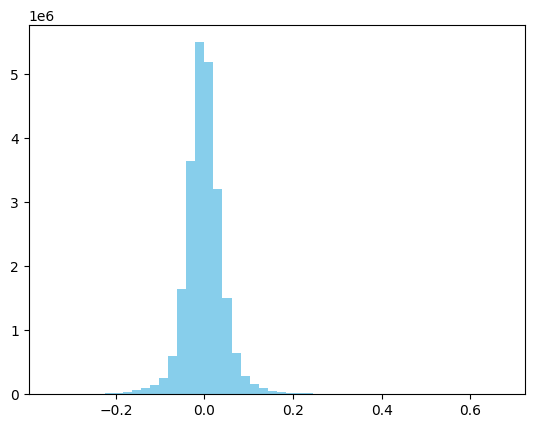

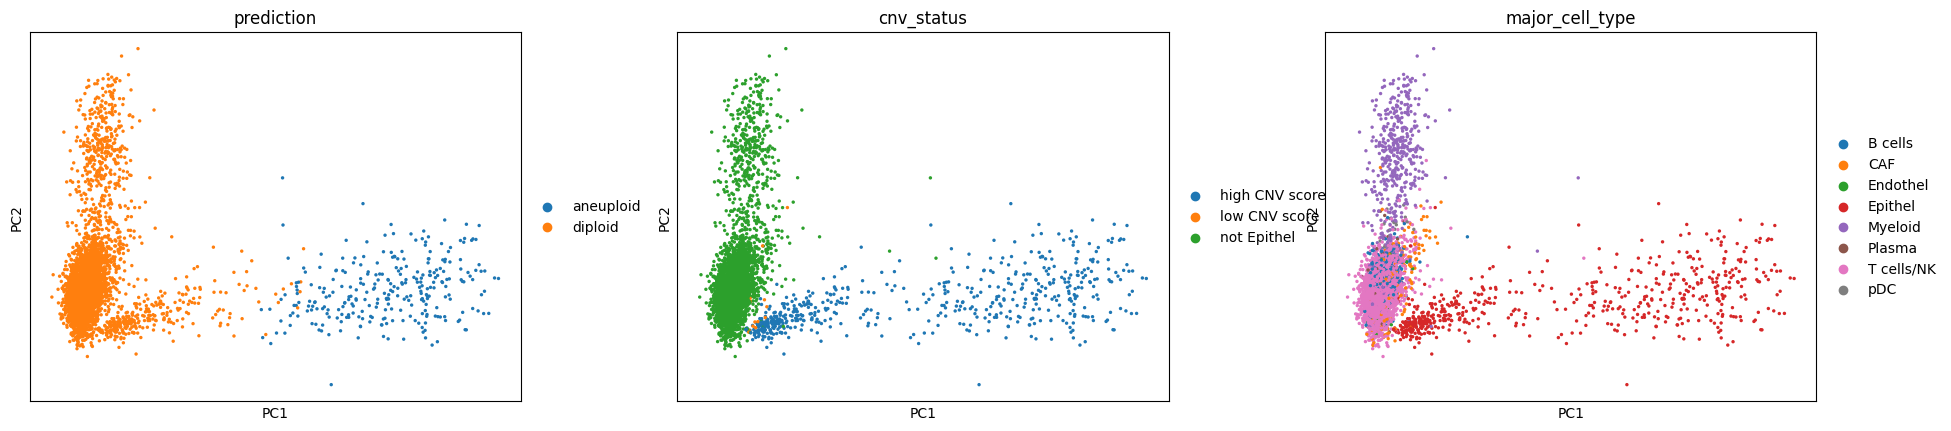

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


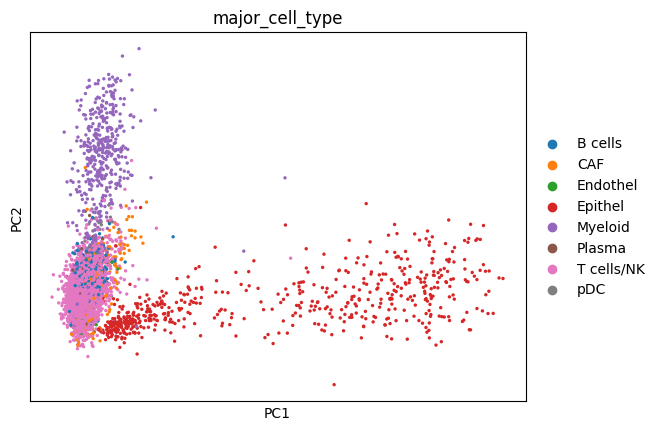

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


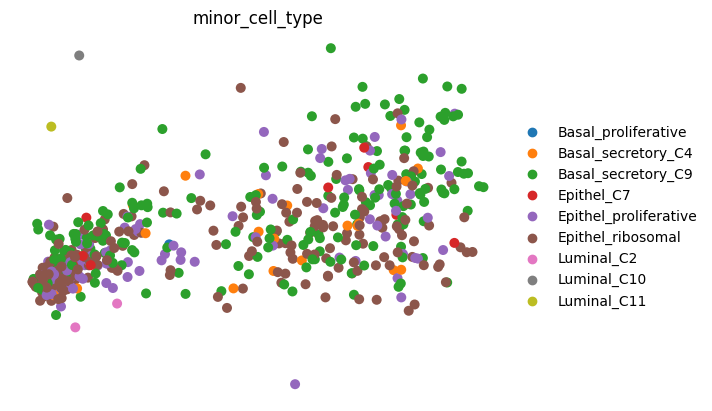

/tmp/ipykernel_1605/1059508321.py:36: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cnv_mtx_copy.obs['copykat_cnv']= cnv_mtx_copy.obs.prediction.replace({'aneuploid':'duplications','diploid':'deletions'})


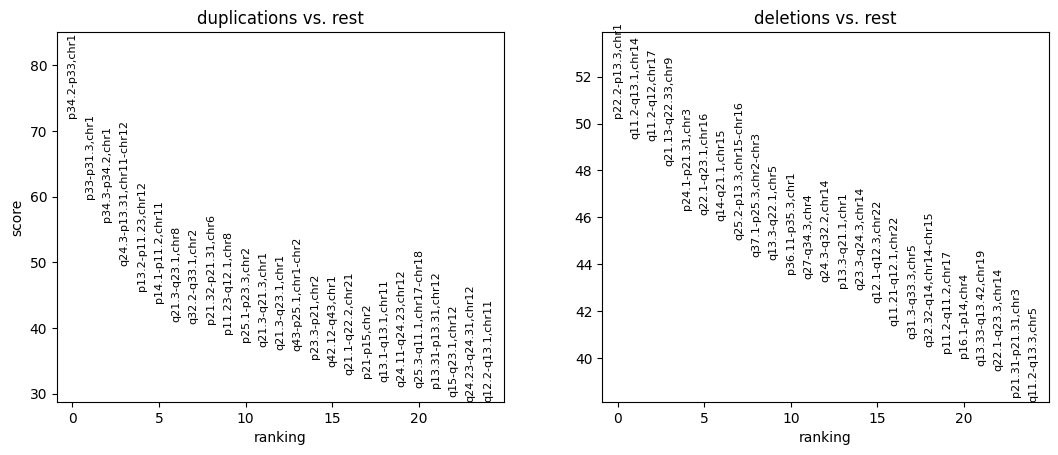

,duplications,deletions
0,"p34.2-p33,chr1","p22.2-p13.3,chr1"
1,"p33-p31.3,chr1","q11.2-q13.1,chr14"
2,"p34.3-p34.2,chr1","q11.2-q12,chr17"
3,"q24.3-p13.31,chr11-chr12","q21.13-q22.33,chr9"
4,"p13.2-p11.23,chr12","p24.1-p21.31,chr3"
5,"p14.1-p11.2,chr11","q22.1-q23.1,chr16"
6,"q21.3-q23.1,chr8","q14-q21.1,chr15"
7,"q32.2-q33.1,chr2","q25.2-p13.3,chr15-chr16"
8,"p21.32-p21.31,chr6","q37.1-p25.3,chr2-chr3"
9,"p11.23-q12.1,chr8","q13.3-q22.1,chr5"


/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


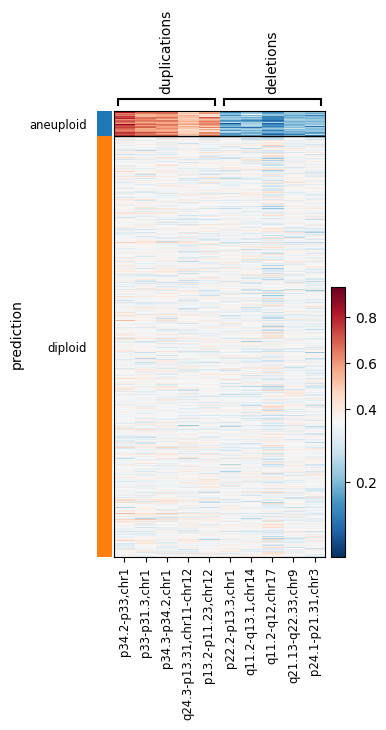

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


,scores,logfoldchanges,pvals,pvals_adj,mean_cnv_aneuploid
names,,,,,
"p34.2-p33,chr1",72.058708,1.262960,6.992555e-188,1.293623e-185,0.355219
"p33-p31.3,chr1",59.669205,1.018961,5.532385e-165,5.117456e-163,0.265780
"p34.3-p34.2,chr1",56.208103,0.920196,5.594547e-159,3.449971e-157,0.238665
"q24.3-p13.31,chr11-chr12",49.485516,0.734420,1.140982e-144,3.015453e-143,0.180826
"p13.2-p11.23,chr12",45.680187,0.819122,2.228297e-134,2.944536e-133,0.204696
"p14.1-p11.2,chr11",43.797485,0.777122,7.351699e-130,6.995146e-129,0.192258
"q21.3-q23.1,chr8",40.940193,0.641285,6.528627e-124,4.645369e-123,0.154198
"q32.2-q33.1,chr2",40.699039,0.632536,4.162193e-124,3.080023e-123,0.156848
"p21.32-p21.31,chr6",40.636086,0.723380,9.180393e-124,6.290269e-123,0.174954


In [17]:
adata,ad_de = CNVmtx_ad_and_top_CNVs("BIOKEY_1_Pre",metadata) # Single sample object, PCA and Top CNVs

In [ ]:
individuals_tables = {}
for sample in good_samples[:]:
    adata,ad_de = CNVmtx_ad_and_top_CNVs(sample,metadata) # Single sample object, PCA and Top CNVs
    ad_de = ad_de[(ad_de.logfoldchanges>0.1)&(ad_de.pvals_adj<0.01)&(ad_de.mean_cnv_aneuploid>0.05)].reset_index()
    print(f"{sample} {ad_de.shape[0]} over threshold")
    ad_de.index = ad_de.index+1
    ad_de['genes_in_bin'] = ''
    for i in range(1,ad_de.shape[0]+1):
        ad_de.at[i,'genes_in_bin'] = bin_to_genes(adata,ad_de.at[i,'names'])
    individuals_tables[sample] = ad_de
ranks_by_indvdl = create_individual_rank_table(individuals_tables)    

### Checking for meaningful abberations 

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  

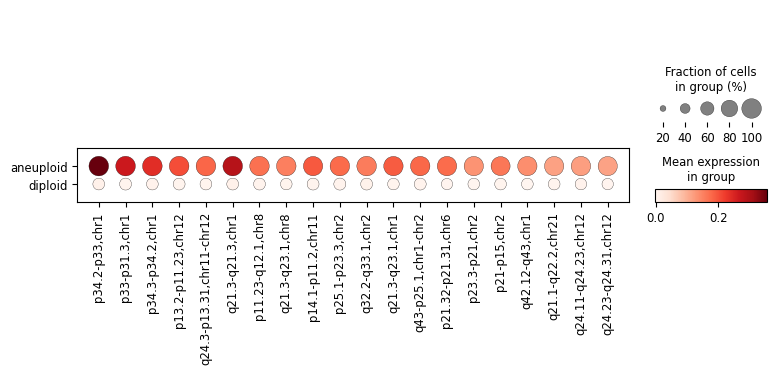

In [13]:
sc.pl.dotplot(adata,var_names = ad_de.names.values[:20],groupby='prediction')

In [14]:
for i in bin_to_genes(adata, "p34.2-p33,chr1"):
    print(i)
print('\n')
for i in bin_to_genes(adata, "p33-p31.3,chr1"):
    print(i)

YBX1
C1orf50
SVBP
SLC2A1
EBNA1BP2
ELOVL1
MED8
HYI
KDM4A
ATP6V0B
DMAP1
ERI3
RNF220
RPS8
EIF2B3
UROD
PRDX1
AKR1A1
GPBP1L1
TMEM69
PIK3R3
POMGNT1
LRRC41
UQCRH
MKNK1


ATPAF1
EFCAB14
CMPK1
RNF11
EPS15
OSBPL9
NRDC
TXNDC12
BTF3L4
PRPF38A
GPX7
ECHDC2
SCP2
MAGOH
YIPF1
HSPB11
LRRC42
TMEM59
MRPL37
USP24
MYSM1
JUN
TM2D1
USP1
PGM1


> *HIF-1 signaling pathway (KEGG) (p34.2-p33,chr1)- (PIK3R3, MKNK1, SLC2A1 (GLUT1)) - The genes in the bin. Expression data can shed light on which gene is amplified
> .Together with p33-p31.3,chr1 -Metabolic pathways*

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots

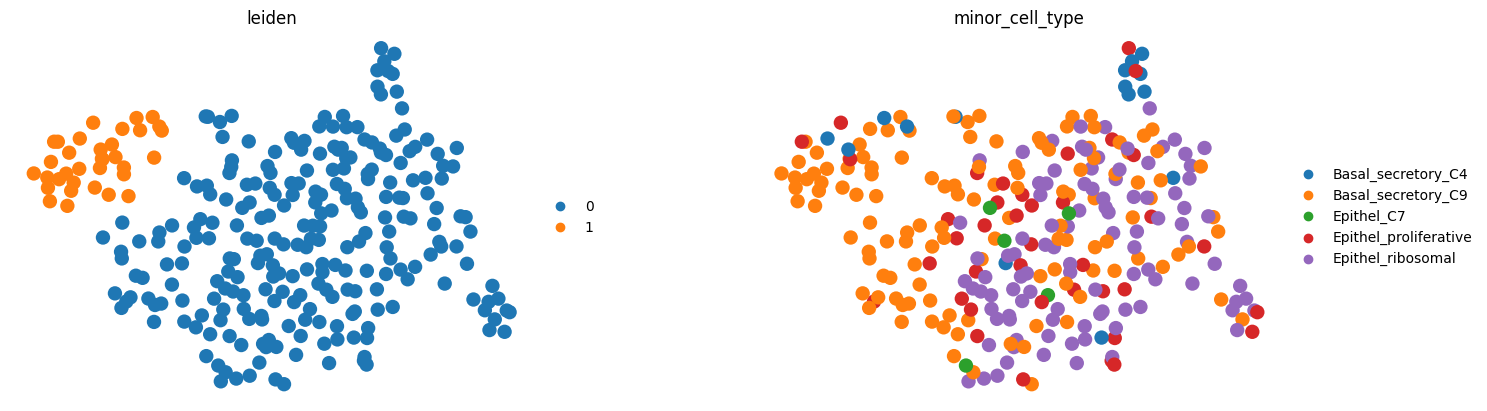

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the 

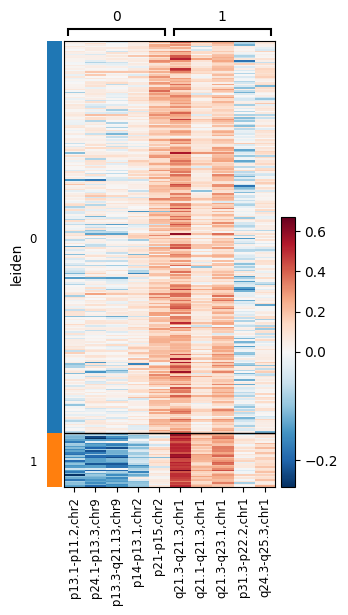

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

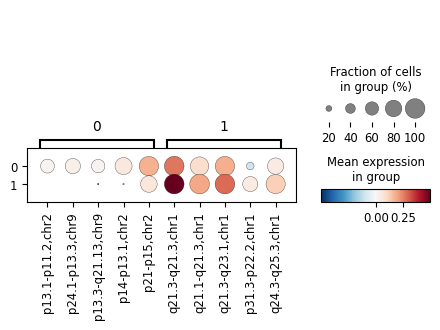

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


,names,scores,logfoldchanges,pvals,pvals_adj
0,"q21.3-q21.3,chr1",8.733933,1.087642,2.459667e-18,1.160471e-16
1,"q21.1-q21.3,chr1",7.419341,1.216355,1.177044e-13,3.110760e-12
2,"q21.3-q23.1,chr1",6.192539,0.723687,5.920284e-10,1.344775e-08
3,"p31.3-p22.2,chr1",5.888652,NaN,3.893589e-09,6.548308e-08
4,"q24.3-q25.3,chr1",5.751340,1.522702,8.853888e-09,1.364974e-07


,names,scores,logfoldchanges,pvals,pvals_adj
180,"p21-p15,chr2",-7.617430,-1.76091,2.587756e-14,7.978914e-13
181,"p14-p13.1,chr2",-8.616880,NaN,6.880296e-18,2.545710e-16
182,"p13.3-q21.13,chr9",-8.731682,NaN,2.509127e-18,1.160471e-16
183,"p24.1-p13.3,chr9",-8.968039,NaN,3.018416e-19,2.792035e-17
184,"p13.1-p11.2,chr2",-9.037820,NaN,1.598274e-19,2.792035e-17


/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


,names,scores,logfoldchanges,pvals,pvals_adj
0,"p13.1-p11.2,chr2",9.037820,NaN,1.598274e-19,2.792035e-17
1,"p24.1-p13.3,chr9",8.968039,NaN,3.018416e-19,2.792035e-17
2,"p13.3-q21.13,chr9",8.731682,NaN,2.509127e-18,1.160471e-16
3,"p14-p13.1,chr2",8.616880,NaN,6.880296e-18,2.545710e-16
4,"p21-p15,chr2",7.617430,1.76091,2.587756e-14,7.978914e-13


,names,scores,logfoldchanges,pvals,pvals_adj
180,"q24.3-q25.3,chr1",-5.751340,-1.522702,8.853888e-09,1.364974e-07
181,"p31.3-p22.2,chr1",-5.888652,NaN,3.893589e-09,6.548308e-08
182,"q21.3-q23.1,chr1",-6.192539,-0.723687,5.920284e-10,1.344775e-08
183,"q21.1-q21.3,chr1",-7.419341,-1.216355,1.177044e-13,3.110760e-12
184,"q21.3-q21.3,chr1",-8.733933,-1.087642,2.459667e-18,1.160471e-16


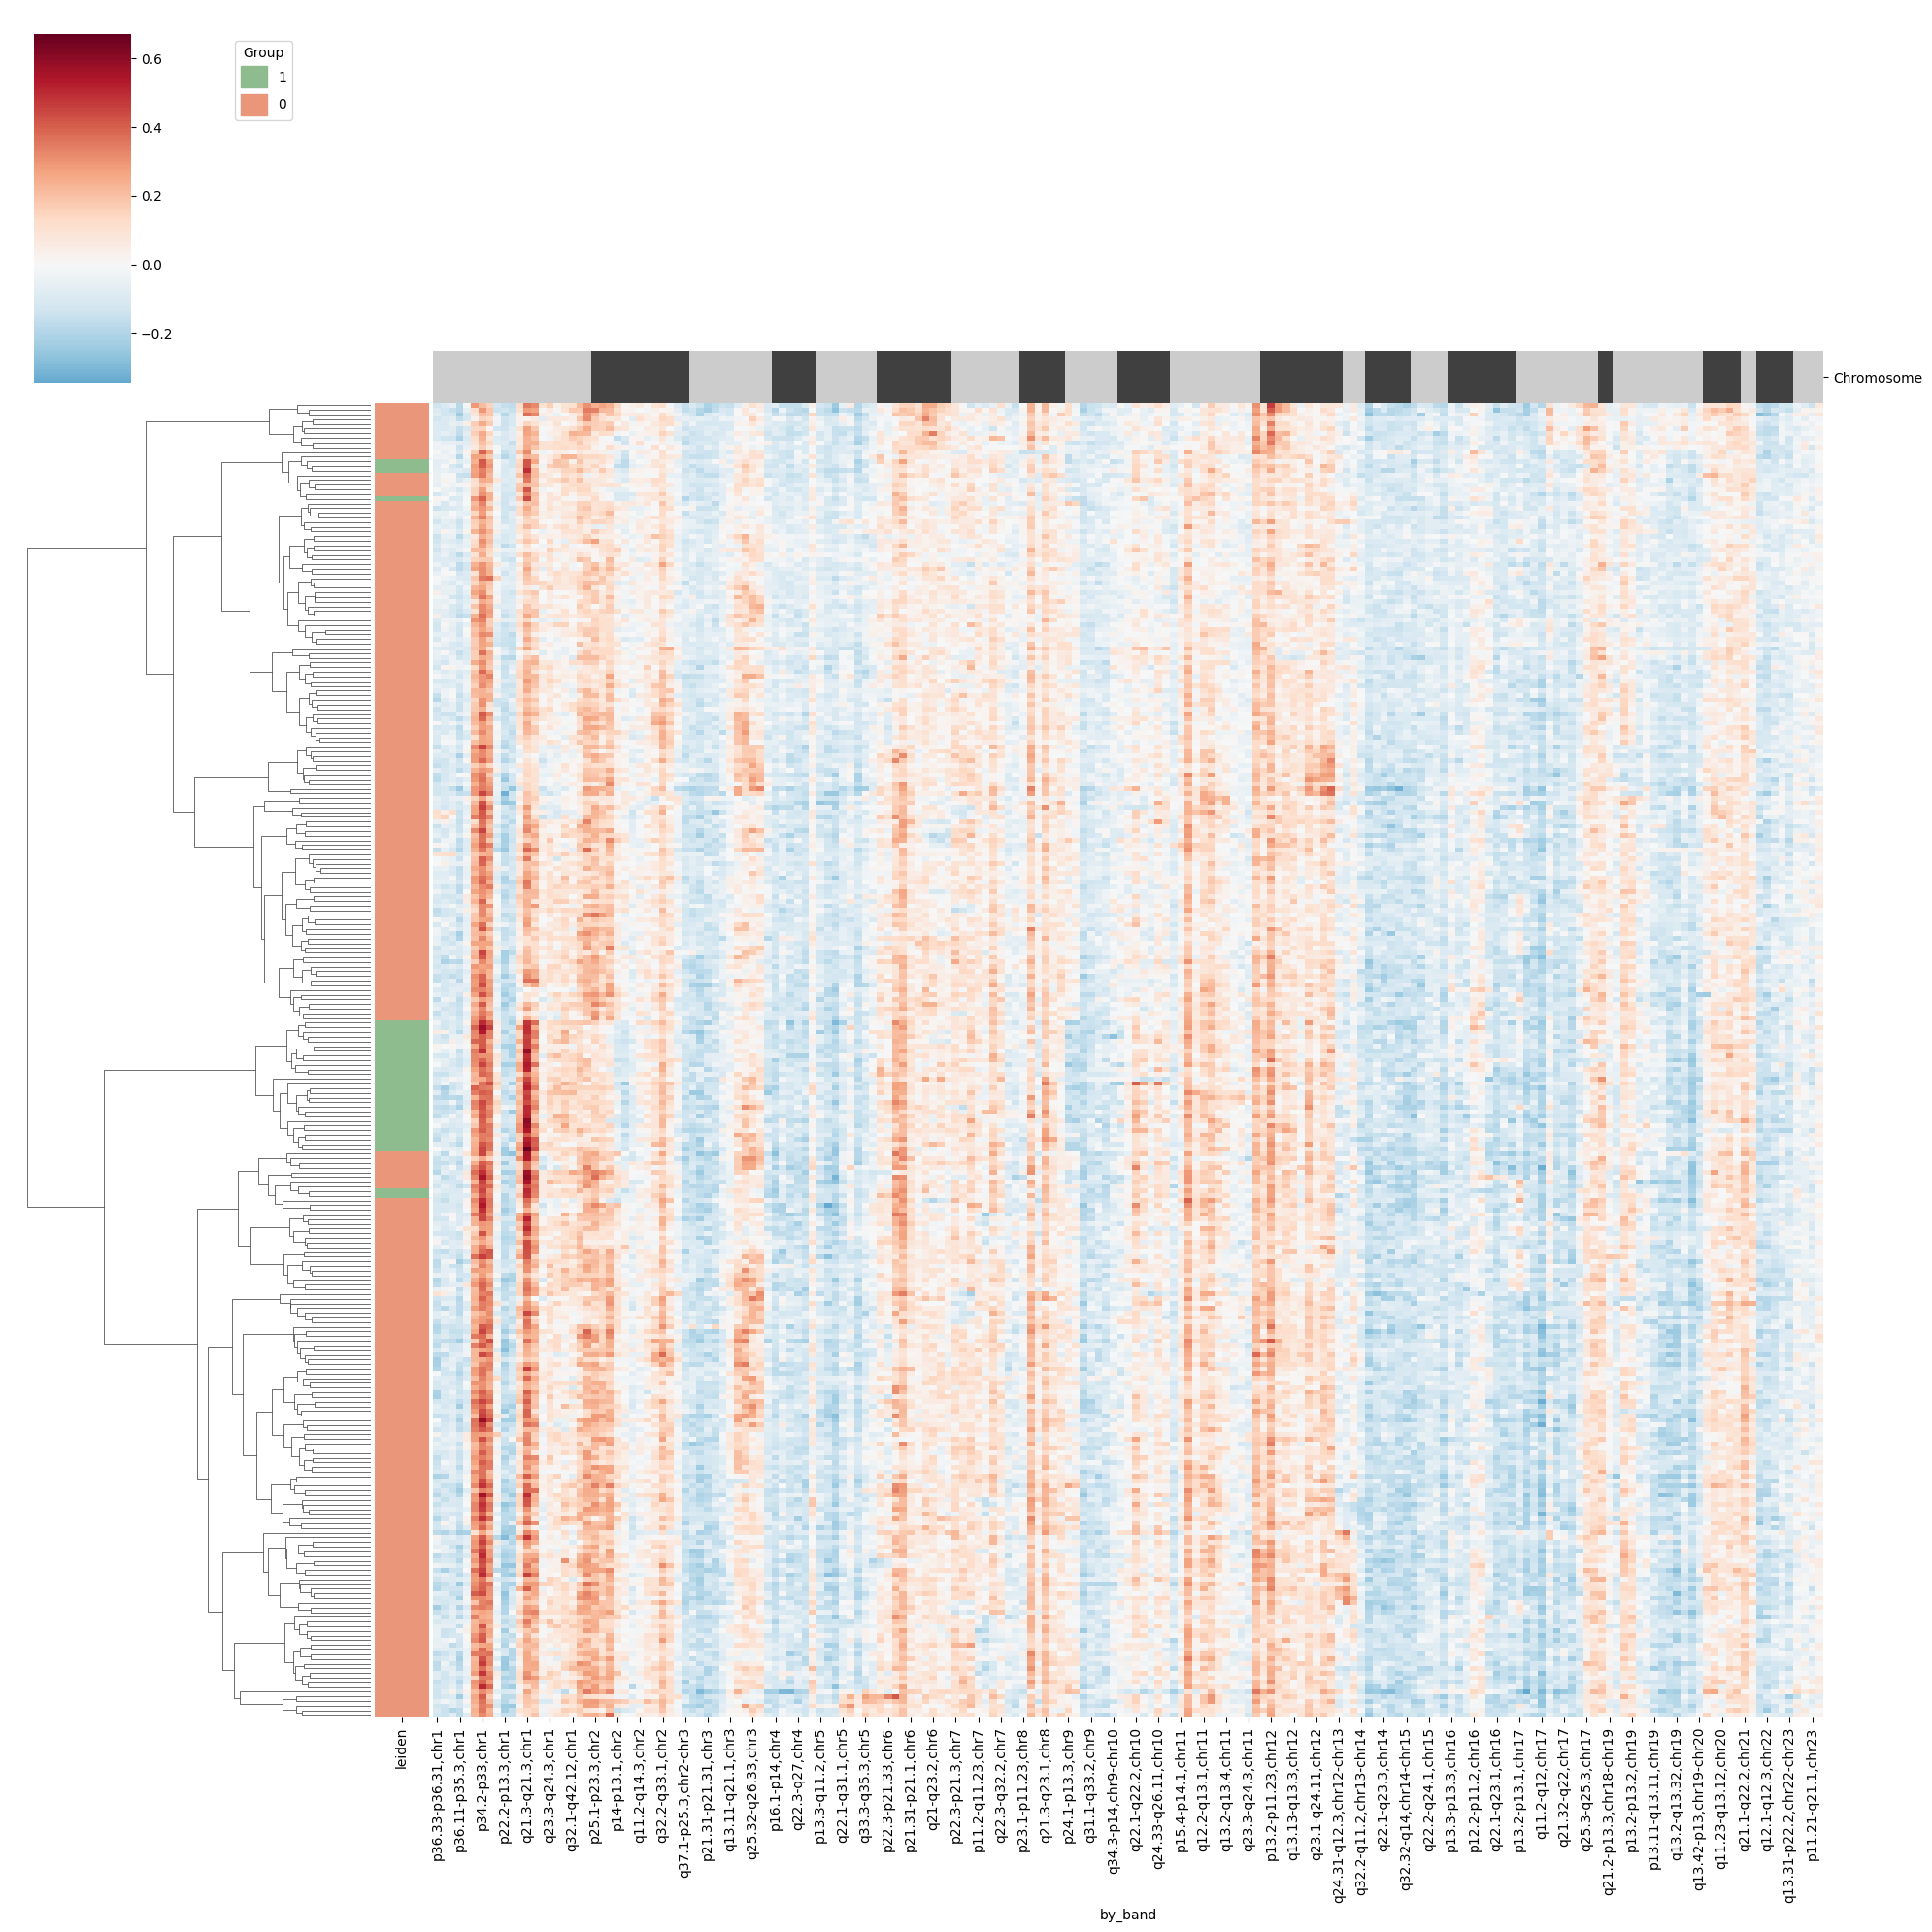

In [15]:
sub_clones(adata,['BIOKEY_1_Pre']) # resolution can be changed for sub clones

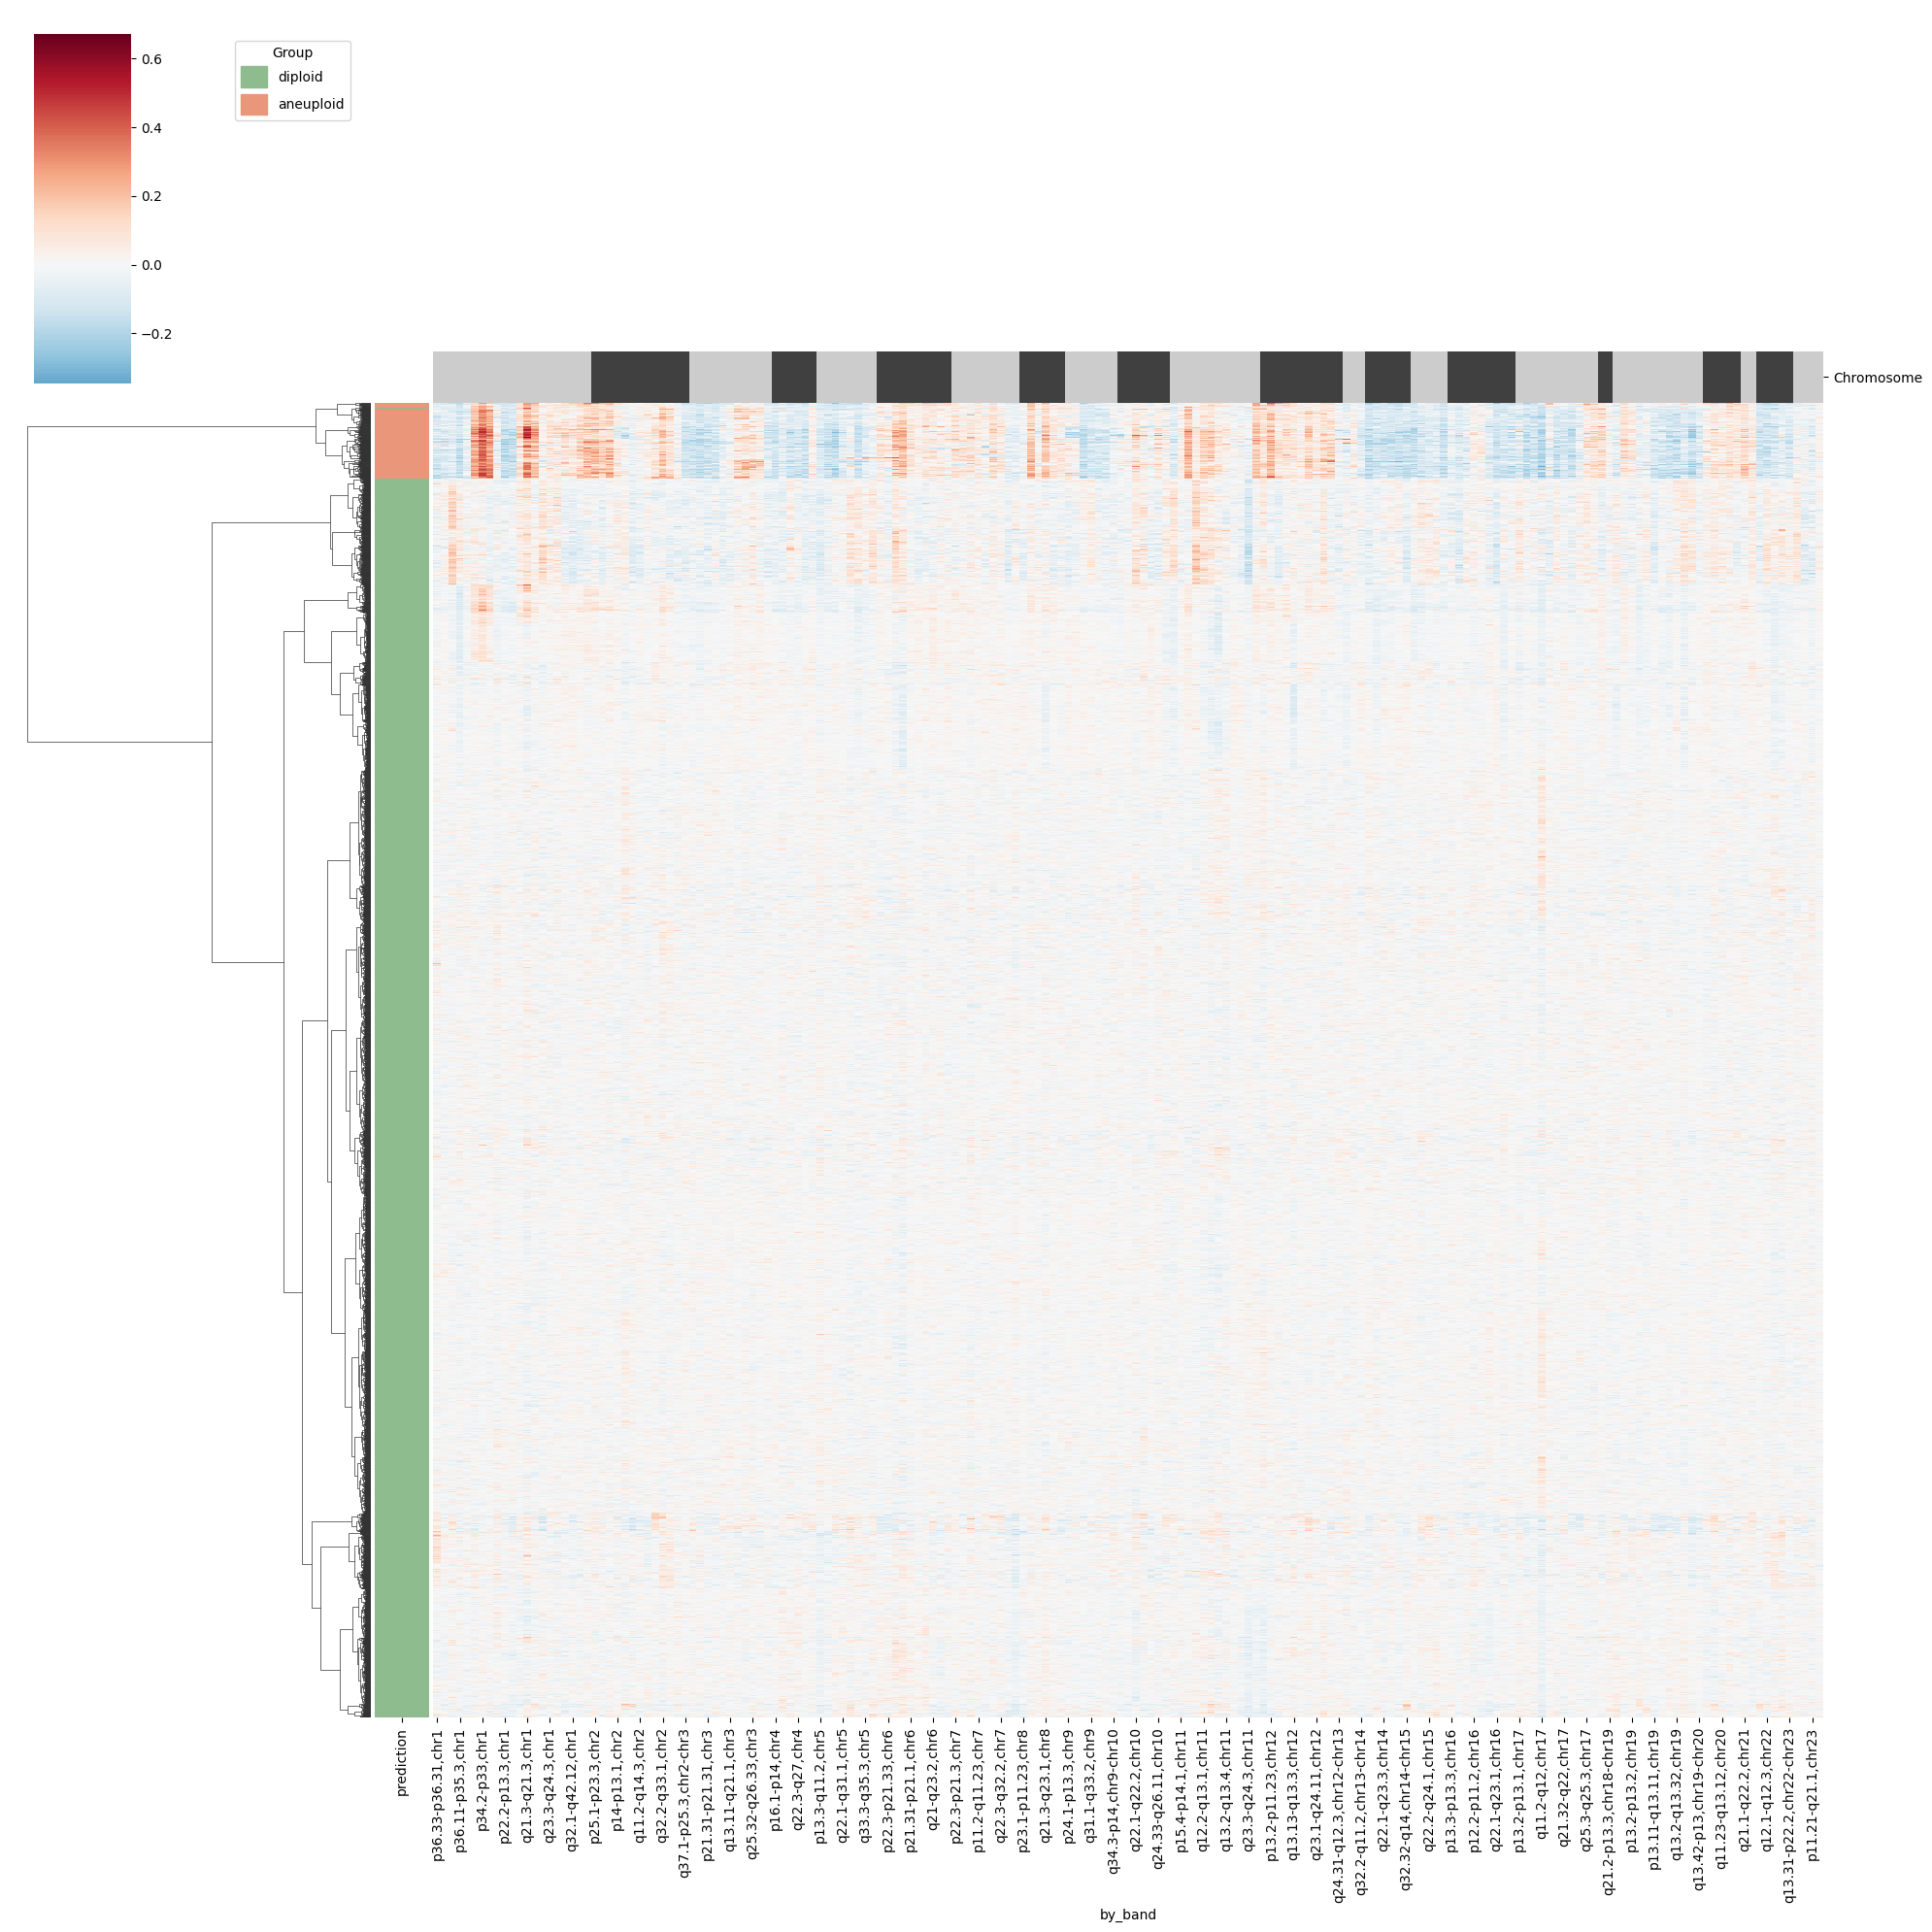

CPU times: user 11.8 s, sys: 325 ms, total: 12.1 s
Wall time: 11.7 s


In [19]:
%%time
heatmap(adata,col_cluster= False,only_tumor=False,infer_cnv=True,cell_ann='prediction',adata_type='single',save_plot = True) # One sample heatmap

# Multi sample integration 

Data dimension:  (90600, 10020)


/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Catego

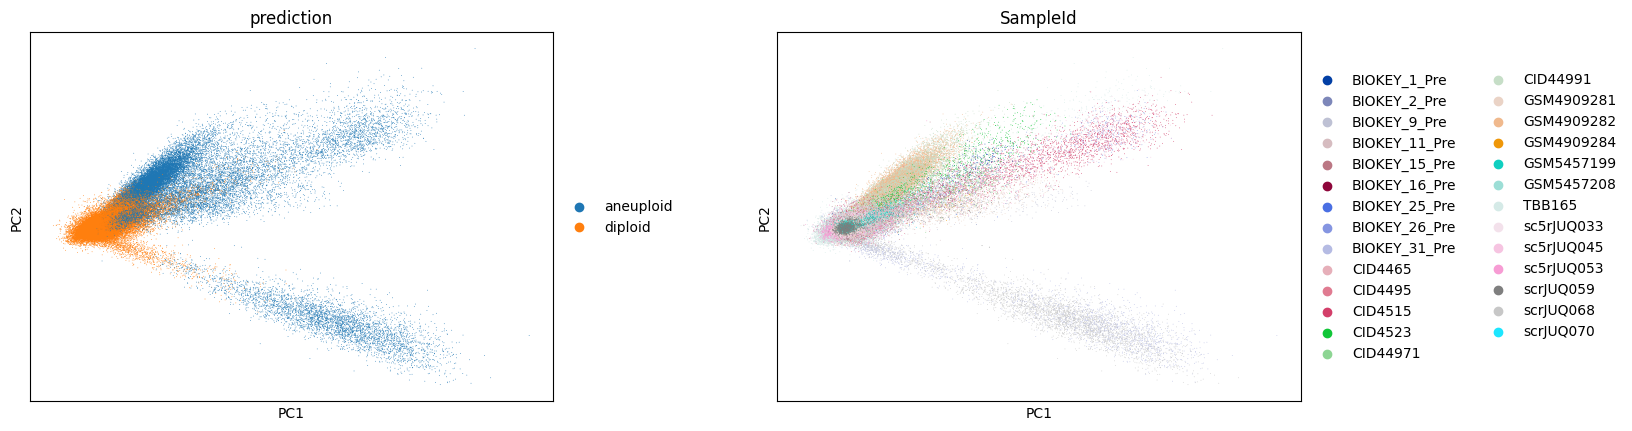

/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homefolder/royl/miniconda3/envs/r_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Catego

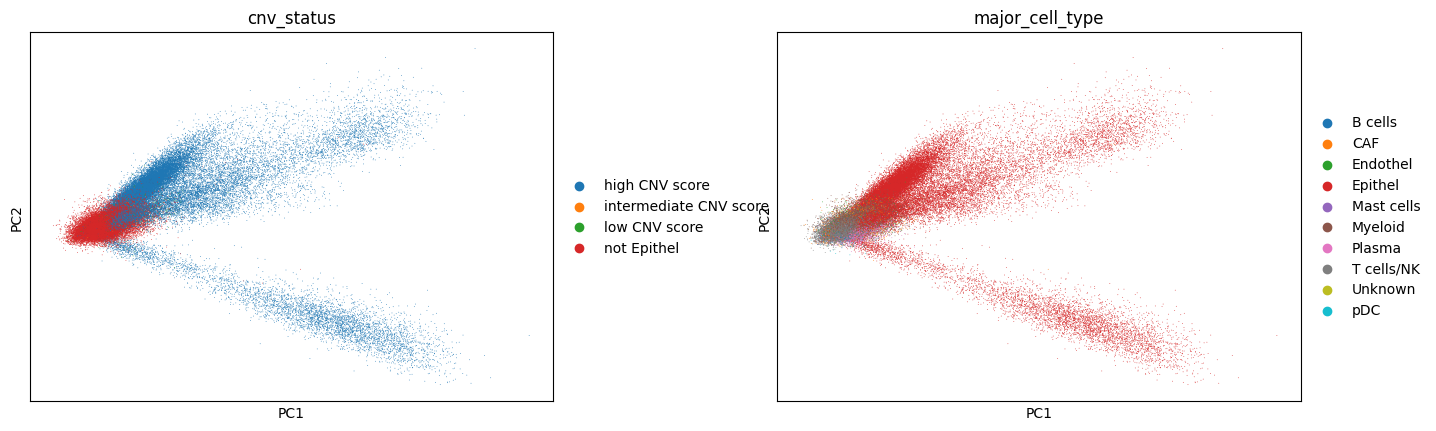

CPU times: user 12min 9s, sys: 3min 38s, total: 15min 47s
Wall time: 3min 8s


In [32]:
%%time
adata_multi = cnv_integration(good_samples[:],metadata) #Multiple samples object, and PCA plots

# Pseudo Bulk